## Set up and import 

In [205]:
import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, GPTNeoXForCausalLM # AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM, 


In [12]:
df = pd.read_csv(f'{os.path.dirname(os.getcwd())}/data/jigsaw_toxic/train.csv') 
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Config

In [29]:
n = 1000
toxic = [df[df['toxic']==1]['comment_text'][i:i+1].to_string(index=False) for i in range(0,n)]
non_toxic = [df[df['toxic']==0]['comment_text'][i:i+1].to_string(index=False) for i in range(0,n)]

In [24]:
model_name = "eleuther-pythia2.8b-hh-sft"
layer = -1


## Load hidden states for base, sft and dpo

In [30]:
x = []
y = []
for idx, model_name in enumerate(["pythia2.8b","eleuther-pythia2.8b-sft","eleuther-pythia2.8b-dpo"]):
  model_SAVEFOLD0 = f"{os.path.dirname(os.getcwd())}/outputs/{model_name}"
  model_SAVEFOLD = f"{model_SAVEFOLD0}/layer{layer}/"

  toxic_f = f"{SAVEFOLD}toxic_hs.npy"
  non_toxic_f = f"{SAVEFOLD}non_toxic_hs.npy"
  toxic_hs = np.load(toxic_f, mmap_mode = 'r')
  non_toxic_hs = np.load(non_toxic_f, mmap_mode = 'r')

  x.append(np.concatenate([non_toxic_hs, toxic_hs],0))
  y.append(np.concatenate([np.array(len(non_toxic)*[2*idx]), np.array(len(toxic)*[2*idx+1])],0))

x = np.concatenate([x[0], x[1], x[2]],0) 
y = np.concatenate([y[0], y[1], y[2]],0) 

In [33]:
x[0]

array([ 0.51742744,  0.92089754,  1.2923046 , ...,  0.40341443,
        2.0513492 , -0.16610062], dtype=float32)

In [34]:
x[2000]

array([ 0.51742744,  0.92089754,  1.2923046 , ...,  0.40341443,
        2.0513492 , -0.16610062], dtype=float32)

In [35]:
x[4000]

array([ 0.51742744,  0.92089754,  1.2923046 , ...,  0.40341443,
        2.0513492 , -0.16610062], dtype=float32)

In [36]:
direction = 0
base_sft_dot = np.empty([int(len(x)/3)])
base_sft_sim = np.empty([int(len(x)/3)])
base_dpo_dot = np.empty([int(len(x)/3)])
base_dpo_sim = np.empty([int(len(x)/3)])
sft_dpo_dot = np.empty([int(len(x)/3)])
sft_dpo_sim = np.empty([int(len(x)/3)])
for i in range(int(len(x)/3)):
    base_sft_dot[i] = np.dot(x[i], x[i+2*n])
    base_sft_sim[i] = base_sft_dot[i]/(np.linalg.norm(x[i])*np.linalg.norm(x[i+2*n]))
    # print(i, i+2*n)

for i in range(int(len(x)/3)):
    base_dpo_dot[i] = np.dot(x[i], x[i+4*n])
    base_dpo_sim[i] = base_dpo_dot[i]/(np.linalg.norm(x[i])*np.linalg.norm(x[i+4*n]))
    # print(i, i+4*n)

for i in range(int(len(x)/3)):
    sft_dpo_dot[i] = np.dot(x[i+2*n], x[i+4*n])
    sft_dpo_sim[i] = sft_dpo_dot[i]/(np.linalg.norm(x[i+2*n])*np.linalg.norm(x[i+4*n]))
    # print(i+2*n, i+4*n)

In [38]:
print(np.mean(base_sft_sim))
print(np.mean(base_dpo_sim))
print(np.mean(sft_dpo_sim))

0.9999999996432282
0.9999999996432282
0.9999999996432282


They're exactly the same

## Transformer lens

In [413]:
from typing import Required, NotRequired

ImportError: cannot import name 'Required' from 'typing' (/usr/lib/python3.8/typing.py)

In [415]:
!pip3 install typing-extensions --upgrade

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from fancy_einsum import einsum
from torchtyping import TensorType as TT
from typing import List, Optional, Callable, Tuple, Union
import functools
from tqdm import tqdm
from IPython.display import display

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import transformer_lens 
torch.set_grad_enabled(False)

In [15]:
model_pythia70m = transformer_lens.HookedTransformer.from_pretrained("pythia-70m")
for parameters in model_pythia70m.parameters():
    print(parameters)
    

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer
Parameter containing:
tensor([[-1.0292e-02, -6.1875e-03,  8.4457e-03,  ..., -9.7581e-03,
          3.2333e-02, -1.7990e-02],
        [-1.3339e-05,  5.1984e-06, -9.7028e-06,  ...,  4.3043e-06,
         -2.6511e-05, -2.4246e-05],
        [-4.0268e-02,  1.3306e-02, -5.5435e-02,  ...,  3.0991e-02,
          5.2964e-02, -1.3343e-02],
        ...,
        [-3.0224e-05,  3.6906e-06, -4.3874e-05,  ..., -1.2522e-05,
          1.8651e-05, -5.0713e-06],
        [-8.6227e-06,  3.7765e-07,  3.4591e-05,  ..., -2.3643e-05,
         -1.3749e-05,  2.0703e-05],
        [ 3.4700e-05,  1.7295e-05,  1.8845e-05,  ..., -2.4936e-06,
         -3.6261e-06, -5.4738e-06]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[-1.9019e-02, -4.5817e-03, -5.8410e-03,  ...,  1.8321e-02,
           4.5304e-02,  5.3359e-03],
         [-1.5665e-02,  1.5674e-03,  1.3378e-02,  ..., -2.1674e-02,
           7.1694e-03, -3.2571e-02],
         [ 4.5031e-

In [12]:
model_pythia70m_sft = transformer_lens.HookedTransformer.from_pretrained("lomahony/eleuther-pythia70m-hh-sft")
model_pythia70m_sft

ValueError: lomahony/eleuther-pythia70m-hh-sft not found. Valid official model names (excl aliases): ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'distilgpt2', 'facebook/opt-125m', 'facebook/opt-1.3b', 'facebook/opt-2.7b', 'facebook/opt-6.7b', 'facebook/opt-13b', 'facebook/opt-30b', 'facebook/opt-66b', 'EleutherAI/gpt-neo-125M', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-neo-2.7B', 'EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b', 'stanford-crfm/alias-gpt2-small-x21', 'stanford-crfm/battlestar-gpt2-small-x49', 'stanford-crfm/caprica-gpt2-small-x81', 'stanford-crfm/darkmatter-gpt2-small-x343', 'stanford-crfm/expanse-gpt2-small-x777', 'stanford-crfm/arwen-gpt2-medium-x21', 'stanford-crfm/beren-gpt2-medium-x49', 'stanford-crfm/celebrimbor-gpt2-medium-x81', 'stanford-crfm/durin-gpt2-medium-x343', 'stanford-crfm/eowyn-gpt2-medium-x777', 'EleutherAI/pythia-14m', 'EleutherAI/pythia-31m', 'EleutherAI/pythia-70m', 'EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1b', 'EleutherAI/pythia-1.4b', 'EleutherAI/pythia-2.8b', 'EleutherAI/pythia-6.9b', 'EleutherAI/pythia-12b', 'EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1b-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped', 'EleutherAI/pythia-70m-v0', 'EleutherAI/pythia-160m-v0', 'EleutherAI/pythia-410m-v0', 'EleutherAI/pythia-1b-v0', 'EleutherAI/pythia-1.4b-v0', 'EleutherAI/pythia-2.8b-v0', 'EleutherAI/pythia-6.9b-v0', 'EleutherAI/pythia-12b-v0', 'EleutherAI/pythia-70m-deduped-v0', 'EleutherAI/pythia-160m-deduped-v0', 'EleutherAI/pythia-410m-deduped-v0', 'EleutherAI/pythia-1b-deduped-v0', 'EleutherAI/pythia-1.4b-deduped-v0', 'EleutherAI/pythia-2.8b-deduped-v0', 'EleutherAI/pythia-6.9b-deduped-v0', 'EleutherAI/pythia-12b-deduped-v0', 'EleutherAI/pythia-160m-seed1', 'EleutherAI/pythia-160m-seed2', 'EleutherAI/pythia-160m-seed3', 'NeelNanda/SoLU_1L_v9_old', 'NeelNanda/SoLU_2L_v10_old', 'NeelNanda/SoLU_4L_v11_old', 'NeelNanda/SoLU_6L_v13_old', 'NeelNanda/SoLU_8L_v21_old', 'NeelNanda/SoLU_10L_v22_old', 'NeelNanda/SoLU_12L_v23_old', 'NeelNanda/SoLU_1L512W_C4_Code', 'NeelNanda/SoLU_2L512W_C4_Code', 'NeelNanda/SoLU_3L512W_C4_Code', 'NeelNanda/SoLU_4L512W_C4_Code', 'NeelNanda/SoLU_6L768W_C4_Code', 'NeelNanda/SoLU_8L1024W_C4_Code', 'NeelNanda/SoLU_10L1280W_C4_Code', 'NeelNanda/SoLU_12L1536W_C4_Code', 'NeelNanda/GELU_1L512W_C4_Code', 'NeelNanda/GELU_2L512W_C4_Code', 'NeelNanda/GELU_3L512W_C4_Code', 'NeelNanda/GELU_4L512W_C4_Code', 'NeelNanda/Attn_Only_1L512W_C4_Code', 'NeelNanda/Attn_Only_2L512W_C4_Code', 'NeelNanda/Attn_Only_3L512W_C4_Code', 'NeelNanda/Attn_Only_4L512W_C4_Code', 'NeelNanda/Attn-Only-2L512W-Shortformer-6B-big-lr', 'NeelNanda/SoLU_1L512W_Wiki_Finetune', 'NeelNanda/SoLU_4L512W_Wiki_Finetune', 'ArthurConmy/redwood_attn_2l', 'llama-7b-hf', 'llama-13b-hf', 'llama-30b-hf', 'llama-65b-hf', 'Llama-2-7b-hf', 'Llama-2-7b-chat-hf', 'Llama-2-13b-hf', 'Llama-2-13b-chat-hf', 'Baidicoot/Othello-GPT-Transformer-Lens', 'bert-base-cased', 'roneneldan/TinyStories-1M', 'roneneldan/TinyStories-3M', 'roneneldan/TinyStories-8M', 'roneneldan/TinyStories-28M', 'roneneldan/TinyStories-33M', 'roneneldan/TinyStories-Instruct-1M', 'roneneldan/TinyStories-Instruct-3M', 'roneneldan/TinyStories-Instruct-8M', 'roneneldan/TinyStories-Instruct-28M', 'roneneldan/TinyStories-Instruct-33M', 'roneneldan/TinyStories-1Layer-21M', 'roneneldan/TinyStories-2Layers-33M', 'roneneldan/TinyStories-Instuct-1Layer-21M', 'roneneldan/TinyStories-Instruct-2Layers-33M', 'stabilityai/stablelm-base-alpha-3b', 'stabilityai/stablelm-base-alpha-7b', 'stabilityai/stablelm-tuned-alpha-3b', 'stabilityai/stablelm-tuned-alpha-7b']

## Model weights

In [218]:
cache_dir = None

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m", cache_dir=cache_dir)
model_base = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-70m", cache_dir=cache_dir)
model_base.cuda()

# tokenizer = AutoTokenizer.from_pretrained("lomahony/eleuther-pythia70m-hh-sft", cache_dir=cache_dir)
model_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-sft", cache_dir=cache_dir)
model_sft.cuda()

# tokenizer = AutoTokenizer.from_pretrained("lomahony/eleuther-pythia70m-hh-dpo", cache_dir=cache_dir)
model_dpo = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-dpo", cache_dir=cache_dir)
model_dpo.cuda()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Look at how much the layers and parameters change on average

In [249]:
i=0
for name, param in model_base.named_parameters():
    if param.requires_grad:
        print(type(param), name, param.size())
        i+=1
print(i)

<class 'torch.nn.parameter.Parameter'> gpt_neox.embed_in.weight torch.Size([50304, 512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.input_layernorm.weight torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.input_layernorm.bias torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.post_attention_layernorm.weight torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.post_attention_layernorm.bias torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.query_key_value.weight torch.Size([1536, 512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.query_key_value.bias torch.Size([1536])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.dense.weight torch.Size([512, 512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.dense.bias torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.mlp.dense_h_to_4h.weight tor

In [238]:
base_sft_diff=[]
base_dpo_diff=[]
sft_dpo_diff=[]
#  len(list(model_dpo.parameters())) # 76

for i in range( len( list( model_base.parameters() ) ) ):
    mean = np.mean( (list(model_base.parameters())[i] - list(model_sft.parameters())[i]).detach().cpu().numpy() )
    base_sft_diff.append( mean )

for i in range( len( list( model_base.parameters() ) ) ):
    mean = np.mean( (list(model_base.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() )
    base_dpo_diff.append( mean )
    
for i in range( len( list( model_sft.parameters() ) ) ):
    mean = np.mean( (list(model_sft.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() )
    sft_dpo_diff.append( mean )

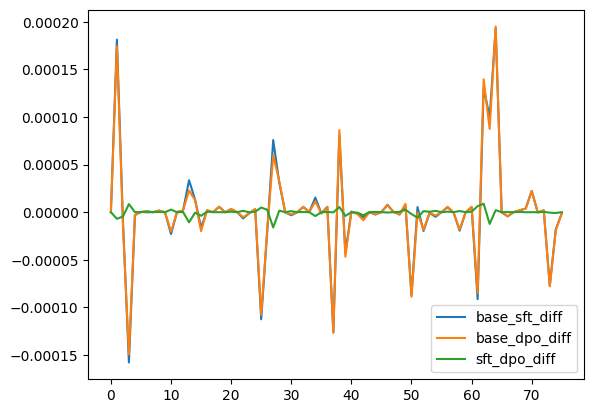

In [246]:
plt.plot(base_sft_diff)
plt.plot(base_dpo_diff)
plt.plot(sft_dpo_diff)
plt.legend(["base_sft_diff", "base_dpo_diff", "sft_dpo_diff"])

In [317]:
base_sft_diff_abs = [abs(item) for item in base_sft_diff]
base_sft_diff_abs_max = list(np.argsort(base_sft_diff_abs)[::-1][:10])
print(base_sft_diff_abs_max)
names = [name for name, param in list(model_base.named_parameters())]
print([base_sft_diff_abs[i] for i in base_sft_diff_abs_max])
[names[i] for i in base_sft_diff_abs_max]

[64, 1, 3, 62, 37, 25, 63, 61, 50, 38]
[0.00019297613, 0.00018124306, 0.00015794032, 0.00013075772, 0.00012637943, 0.00011255813, 9.9787256e-05, 9.142619e-05, 8.695412e-05, 8.076195e-05]


['gpt_neox.layers.5.post_attention_layernorm.bias',
 'gpt_neox.layers.0.input_layernorm.weight',
 'gpt_neox.layers.0.post_attention_layernorm.weight',
 'gpt_neox.layers.5.input_layernorm.bias',
 'gpt_neox.layers.3.input_layernorm.weight',
 'gpt_neox.layers.2.input_layernorm.weight',
 'gpt_neox.layers.5.post_attention_layernorm.weight',
 'gpt_neox.layers.5.input_layernorm.weight',
 'gpt_neox.layers.4.input_layernorm.bias',
 'gpt_neox.layers.3.input_layernorm.bias']

### What proportion of model weights haven't changed?

In [352]:
base_sft_nonzero=[]
base_dpo_nonzero=[]
sft_dpo_nonzero=[]
#  len(list(model_dpo.parameters())) # 76

for i in range( len( list( model_base.parameters() ) ) ):
    non_zero = ((list(model_base.parameters())[i] - list(model_sft.parameters())[i]).detach().cpu().numpy() != 0).sum()
    size = 1
    for dim in np.shape( ((list(model_base.parameters())[i] - list(model_sft.parameters())[i]).detach().cpu().numpy() != 0) ): 
        size *= dim
    base_sft_nonzero.append( non_zero/size )

for i in range( len( list( model_base.parameters() ) ) ):
    non_zero = ((list(model_base.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0).sum()
    size = 1
    for dim in np.shape( ((list(model_base.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0) ): 
        size *= dim
    base_dpo_nonzero.append( non_zero/size )

for i in range( len( list( model_sft.parameters() ) ) ):
    non_zero = ((list(model_sft.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0).sum()
    size = 1
    for dim in np.shape( ((list(model_sft.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0) ): 
        size *= dim
    sft_dpo_nonzero.append( non_zero/size )

In [403]:
base_sft_nonzero_sorted = np.argsort(base_sft_nonzero)
[base_sft_nonzero[i] for i in base_sft_nonzero_sorted][:10]
names = [name for name, param in list(model_base.named_parameters())]
print("Layers least affected by fine tuning: ")
print([names[i] for i in base_sft_nonzero_sorted[:10]])
print("How much these layers are affected by fine tuning: ")
print([base_sft_nonzero[i] for i in base_sft_nonzero_sorted[:10]])

Layers least affected by fine tuning: 
['gpt_neox.embed_in.weight', 'gpt_neox.layers.3.attention.query_key_value.bias', 'gpt_neox.layers.5.attention.query_key_value.bias', 'gpt_neox.layers.4.attention.query_key_value.bias', 'gpt_neox.layers.4.input_layernorm.weight', 'gpt_neox.final_layer_norm.bias', 'gpt_neox.final_layer_norm.weight', 'gpt_neox.layers.2.attention.query_key_value.bias', 'gpt_neox.layers.2.post_attention_layernorm.weight', 'gpt_neox.layers.3.input_layernorm.weight']
How much these layers are affected by fine tuning: 
[0.841842146623529, 0.9876302083333334, 0.98828125, 0.9889322916666666, 0.99609375, 0.99609375, 0.998046875, 0.998046875, 0.998046875, 0.998046875]


In [402]:
base_dpo_nonzero_sorted = np.argsort(base_dpo_nonzero)
[base_dpo_nonzero[i] for i in base_dpo_nonzero_sorted][:10]
names = [name for name, param in list(model_base.named_parameters())]
print("Layers least affected by fine tuning: ")
print([names[i] for i in base_dpo_nonzero_sorted[:10]])
print("How much these layers are affected by fine tuning: ")
print([base_dpo_nonzero[i] for i in base_dpo_nonzero_sorted[:10]])

Layers least affected by fine tuning: 
['gpt_neox.embed_in.weight', 'gpt_neox.layers.3.attention.query_key_value.bias', 'gpt_neox.layers.5.attention.query_key_value.bias', 'gpt_neox.layers.4.attention.query_key_value.bias', 'gpt_neox.final_layer_norm.weight', 'gpt_neox.layers.4.post_attention_layernorm.weight', 'gpt_neox.layers.4.input_layernorm.weight', 'gpt_neox.final_layer_norm.bias', 'gpt_neox.layers.1.attention.query_key_value.bias', 'gpt_neox.layers.2.attention.query_key_value.bias']
How much these layers are affected by fine tuning: 
[0.8753407796223959, 0.9856770833333334, 0.9889322916666666, 0.9895833333333334, 0.99609375, 0.998046875, 0.998046875, 0.998046875, 0.9986979166666666, 0.9993489583333334]


In [401]:
sft_dpo_nonzero_sorted = np.argsort(sft_dpo_nonzero)
[sft_dpo_nonzero[i] for i in sft_dpo_nonzero_sorted][:10]
names = [name for name, param in list(model_base.named_parameters())]
print("Layers least affected by fine tuning: ")
print([names[i] for i in sft_dpo_nonzero_sorted[:10]])
print("How much these layers are affected by fine tuning: ")
print([sft_dpo_nonzero[i] for i in sft_dpo_nonzero_sorted[:10]])

Layers least affected by fine tuning: 
['gpt_neox.layers.5.attention.query_key_value.bias', 'gpt_neox.layers.4.attention.query_key_value.bias', 'gpt_neox.embed_in.weight', 'gpt_neox.layers.3.attention.query_key_value.bias', 'gpt_neox.layers.2.attention.query_key_value.bias', 'gpt_neox.layers.1.attention.query_key_value.bias', 'gpt_neox.layers.0.attention.query_key_value.bias', 'gpt_neox.final_layer_norm.weight', 'gpt_neox.final_layer_norm.bias', 'gpt_neox.layers.4.input_layernorm.weight']
How much these layers are affected by fine tuning: 
[0.8079427083333334, 0.8470052083333334, 0.8749510010386848, 0.8802083333333334, 0.970703125, 0.9837239583333334, 0.9915364583333334, 0.994140625, 0.99609375, 0.998046875]


### Looking at layers and stuff...

In [405]:
# list(model_dpo.children())

In [404]:
# i=0
# for name, module in model_dpo.named_modules():
#     # print(name, sep = " ")
#     if list(module.children()) == []:
#         print(name, end = " ")
#         print(module)
#         i+=1
# print(i)

In [149]:
import torch

def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [406]:
# get_children(model_dpo) # len(get_children(model_dpo)) 70